In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Load Feature-Engineered Data

try:
    df_features = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/data_features_engineered.csv', 
                            index_col='Datetime',
                            parse_dates=True)
    print(f" Data loaded: {len(df_features):,} records")
    print(f" Features: {len(df_features.columns)} columns")
    print(f" Date range: {df_features.index.min()} to {df_features.index.max()}")

except FileNotFoundError:
    print(" Error: data_features_engineered.csv not found!")
    exit()

 Data loaded: 34,421 records
 Features: 78 columns
 Date range: 2006-12-23 17:00:00 to 2010-11-26 21:00:00


In [4]:
# Preparing Features and Target Variable

# Target variable
target_col = 'Global_active_power'

# Features to exclude (target and original device readings)
exclude_cols = [target_col, 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Get feature columns
feature_cols = [col for col in df_features.columns if col not in exclude_cols]

print(f"\n Dataset Summary:")
print(f"   • Target variable: {target_col}")
print(f"   • Number of features: {len(feature_cols)}")
print(f"   • Total samples: {len(df_features):,}")

# Separate features (X) and target (y)
X = df_features[feature_cols]
y = df_features[target_col]

print(f"\n Features (X) shape: {X.shape}")
print(f" Target (y) shape: {y.shape}")


 Dataset Summary:
   • Target variable: Global_active_power
   • Number of features: 74
   • Total samples: 34,421

 Features (X) shape: (34421, 74)
 Target (y) shape: (34421,)


In [5]:
# Splitting Data (Train/Validation/Test)

# Chronological split (important for time series)
total_samples = len(df_features)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

# Split data
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size:train_size+val_size]
y_val = y.iloc[train_size:train_size+val_size]

X_test = X.iloc[train_size+val_size:]
y_test = y.iloc[train_size+val_size:]

print(f"\n Dataset Split:")
print(f"   • Training:   {len(X_train):,} samples ({len(X_train)/total_samples*100:.1f}%)")
print(f"   • Validation: {len(X_val):,} samples ({len(X_val)/total_samples*100:.1f}%)")
print(f"   • Test:       {len(X_test):,} samples ({len(X_test)/total_samples*100:.1f}%)")

print(f"\n Date Ranges:")
print(f"   • Train:      {X_train.index[0].strftime('%Y-%m-%d')} to {X_train.index[-1].strftime('%Y-%m-%d')}")
print(f"   • Validation: {X_val.index[0].strftime('%Y-%m-%d')} to {X_val.index[-1].strftime('%Y-%m-%d')}")
print(f"   • Test:       {X_test.index[0].strftime('%Y-%m-%d')} to {X_test.index[-1].strftime('%Y-%m-%d')}")


 Dataset Split:
   • Training:   24,094 samples (70.0%)
   • Validation: 5,163 samples (15.0%)
   • Test:       5,164 samples (15.0%)

 Date Ranges:
   • Train:      2006-12-23 to 2009-09-22
   • Validation: 2009-09-22 to 2010-04-25
   • Test:       2010-04-25 to 2010-11-26


In [6]:
# Scaling Features

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only (prevent data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(" StandardScaler applied")
print(" Fitted on training data only")
print(" Transformed train, validation, and test sets")

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

 StandardScaler applied
 Fitted on training data only
 Transformed train, validation, and test sets


In [7]:
# Training Linear Regression Model

# Initialize model
model_lr = LinearRegression()

# Train model
print("\n Training in progress...")
model_lr.fit(X_train_scaled, y_train)
print(" Model training completed!")

# Model parameters
print(f"\n Model Parameters:")
print(f"   • Coefficients: {len(model_lr.coef_)}")
print(f"   • Intercept: {model_lr.intercept_:.4f}")

# Top 10 most important features (by coefficient magnitude)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model_lr.coef_
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print(f"\n Top 10 Most Important Features:")
for i, row in feature_importance.head(10).iterrows():
    print(f"   {row['Feature']:50s} : {row['Coefficient']:+.6f}")


 Training in progress...
 Model training completed!

 Model Parameters:
   • Coefficients: 74
   • Intercept: 1.0702

 Top 10 Most Important Features:
   Global_active_power_rolling_mean_3h                : +0.287188
   total_sub_metering                                 : +0.273170
   unmetered_power                                    : +0.230536
   Global_active_power_diff_1h                        : +0.199576
   Global_active_power_lag_1h                         : +0.155417
   Global_active_power_lag_2h                         : -0.111945
   Global_active_power_momentum_24h                   : +0.080797
   Global_active_power_ema_12h                        : +0.045356
   Global_active_power_rolling_mean_24h               : +0.037834
   Global_active_power_diff_24h                       : +0.015048


In [8]:
# Making Predictions

# Predictions on all sets
y_train_pred = model_lr.predict(X_train_scaled)
y_val_pred = model_lr.predict(X_val_scaled)
y_test_pred = model_lr.predict(X_test_scaled)

print(" Predictions completed for all datasets")
print(f"   • Training predictions: {len(y_train_pred):,}")
print(f"   • Validation predictions: {len(y_val_pred):,}")
print(f"   • Test predictions: {len(y_test_pred):,}")

 Predictions completed for all datasets
   • Training predictions: 24,094
   • Validation predictions: 5,163
   • Test predictions: 5,164


In [9]:
# Evaluating Model Performance

def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Dataset': dataset_name,
        'MAE': mae,
        'RMSE': rmse,
        'R² Score': r2,
        'MAPE (%)': mape
    }

# Evaluate on all datasets
train_metrics = evaluate_model(y_train, y_train_pred, 'Training')
val_metrics = evaluate_model(y_val, y_val_pred, 'Validation')
test_metrics = evaluate_model(y_test, y_test_pred, 'Test')

# Create metrics DataFrame
metrics_df = pd.DataFrame([train_metrics, val_metrics, test_metrics])

print("\n MODEL PERFORMANCE METRICS:")
print(metrics_df.to_string(index=False))

print("\n Metric Explanations:")
print("   • MAE (Mean Absolute Error): Average absolute difference (lower is better)")
print("   • RMSE (Root Mean Squared Error): Penalizes large errors more (lower is better)")
print("   • R² Score: Proportion of variance explained (higher is better, max=1.0)")
print("   • MAPE (Mean Absolute Percentage Error): Average error percentage (lower is better)")

# Check for overfitting
print("\n Overfitting Check:")
train_test_gap = abs(train_metrics['R² Score'] - test_metrics['R² Score'])
if train_test_gap < 0.05:
    print(f"    Good generalization (R² gap: {train_test_gap:.4f})")
elif train_test_gap < 0.10:
    print(f"    Slight overfitting (R² gap: {train_test_gap:.4f})")
else:
    print(f"    Significant overfitting (R² gap: {train_test_gap:.4f})")


 MODEL PERFORMANCE METRICS:
   Dataset      MAE     RMSE  R² Score  MAPE (%)
  Training 0.001470 0.004142  0.999979  0.261209
Validation 0.012870 0.109332  0.984240  0.735895
      Test 0.002968 0.010315  0.999779  0.644563

 Metric Explanations:
   • MAE (Mean Absolute Error): Average absolute difference (lower is better)
   • RMSE (Root Mean Squared Error): Penalizes large errors more (lower is better)
   • R² Score: Proportion of variance explained (higher is better, max=1.0)
   • MAPE (Mean Absolute Percentage Error): Average error percentage (lower is better)

 Overfitting Check:
    Good generalization (R² gap: 0.0002)


 Visualization saved as 'module4_baseline_model_results.png'


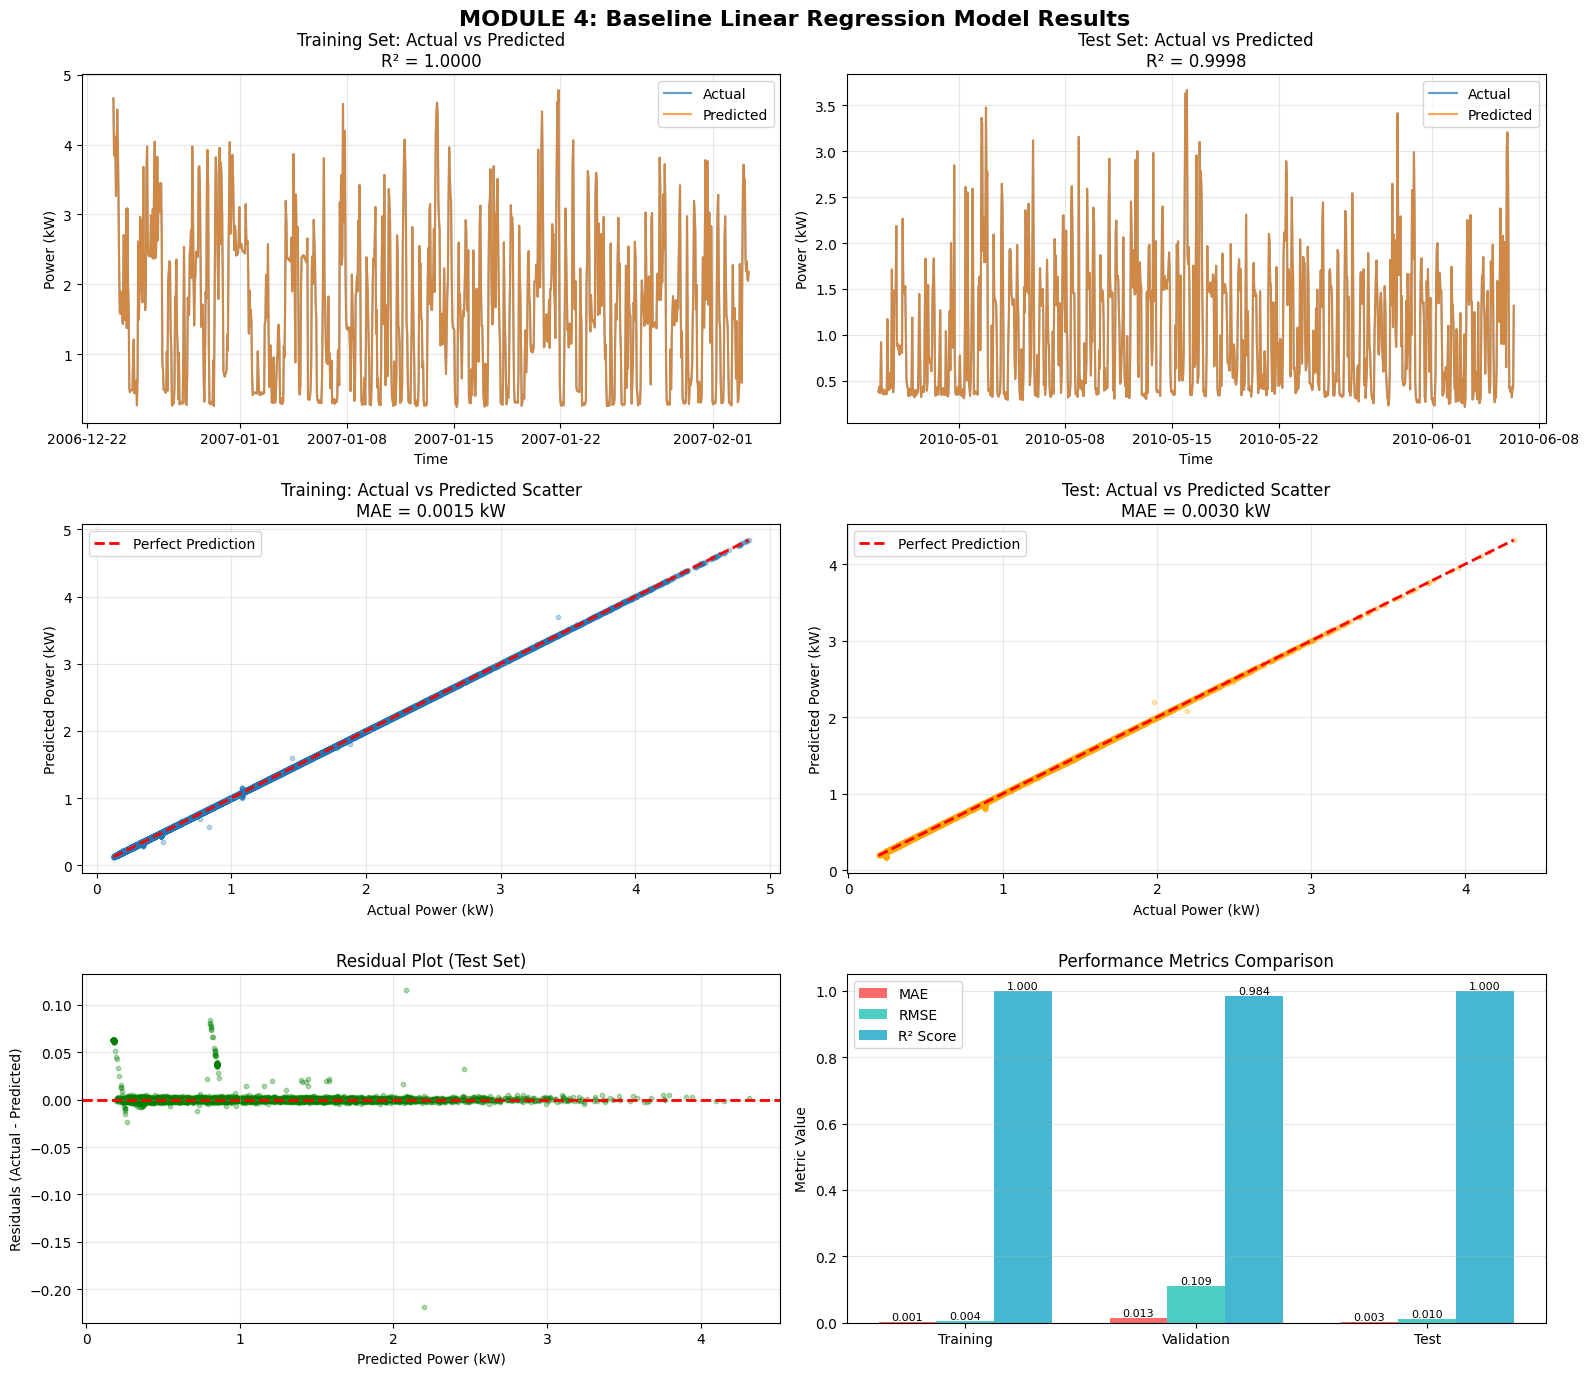

In [10]:
# Creating Prediction Visualizations

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('MODULE 4: Baseline Linear Regression Model Results',
        fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted (Training)
ax1 = axes[0, 0]
sample_train = min(1000, len(y_train))
ax1.plot(y_train.index[:sample_train], y_train.values[:sample_train], 
        label='Actual', linewidth=1.5, alpha=0.7)
ax1.plot(y_train.index[:sample_train], y_train_pred[:sample_train], 
        label='Predicted', linewidth=1.5, alpha=0.7)
ax1.set_title(f'Training Set: Actual vs Predicted\nR² = {train_metrics["R² Score"]:.4f}')
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (kW)')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Actual vs Predicted (Test)
ax2 = axes[0, 1]
sample_test = min(1000, len(y_test))
ax2.plot(y_test.index[:sample_test], y_test.values[:sample_test], 
        label='Actual', linewidth=1.5, alpha=0.7)
ax2.plot(y_test.index[:sample_test], y_test_pred[:sample_test], 
        label='Predicted', linewidth=1.5, alpha=0.7)
ax2.set_title(f'Test Set: Actual vs Predicted\nR² = {test_metrics["R² Score"]:.4f}')
ax2.set_xlabel('Time')
ax2.set_ylabel('Power (kW)')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Scatter Plot (Training)
ax3 = axes[1, 0]
ax3.scatter(y_train, y_train_pred, alpha=0.3, s=10)
ax3.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
        'r--', linewidth=2, label='Perfect Prediction')
ax3.set_title(f'Training: Actual vs Predicted Scatter\nMAE = {train_metrics["MAE"]:.4f} kW')
ax3.set_xlabel('Actual Power (kW)')
ax3.set_ylabel('Predicted Power (kW)')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Scatter Plot (Test)
ax4 = axes[1, 1]
ax4.scatter(y_test, y_test_pred, alpha=0.3, s=10, color='orange')
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
        'r--', linewidth=2, label='Perfect Prediction')
ax4.set_title(f'Test: Actual vs Predicted Scatter\nMAE = {test_metrics["MAE"]:.4f} kW')
ax4.set_xlabel('Actual Power (kW)')
ax4.set_ylabel('Predicted Power (kW)')
ax4.legend()
ax4.grid(alpha=0.3)

# Plot 5: Residual Plot
ax5 = axes[2, 0]
residuals_test = y_test - y_test_pred
ax5.scatter(y_test_pred, residuals_test, alpha=0.3, s=10, color='green')
ax5.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax5.set_title('Residual Plot (Test Set)')
ax5.set_xlabel('Predicted Power (kW)')
ax5.set_ylabel('Residuals (Actual - Predicted)')
ax5.grid(alpha=0.3)

# Plot 6: Metrics Comparison Bar Chart
ax6 = axes[2, 1]
metrics_comparison = metrics_df[['Dataset', 'MAE', 'RMSE', 'R² Score']]
x = np.arange(len(metrics_comparison))
width = 0.25

bars1 = ax6.bar(x - width, metrics_comparison['MAE'], width, label='MAE', color='#FF6B6B')
bars2 = ax6.bar(x, metrics_comparison['RMSE'], width, label='RMSE', color='#4ECDC4')
bars3 = ax6.bar(x + width, metrics_comparison['R² Score'], width, label='R² Score', color='#45B7D1')

ax6.set_title('Performance Metrics Comparison')
ax6.set_ylabel('Metric Value')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_comparison['Dataset'])
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('module4_baseline_model_results.png', dpi=300, bbox_inches='tight')
print(" Visualization saved as 'module4_baseline_model_results.png'")
plt.show()

 Feature importance visualization saved as 'module4_feature_importance.png'


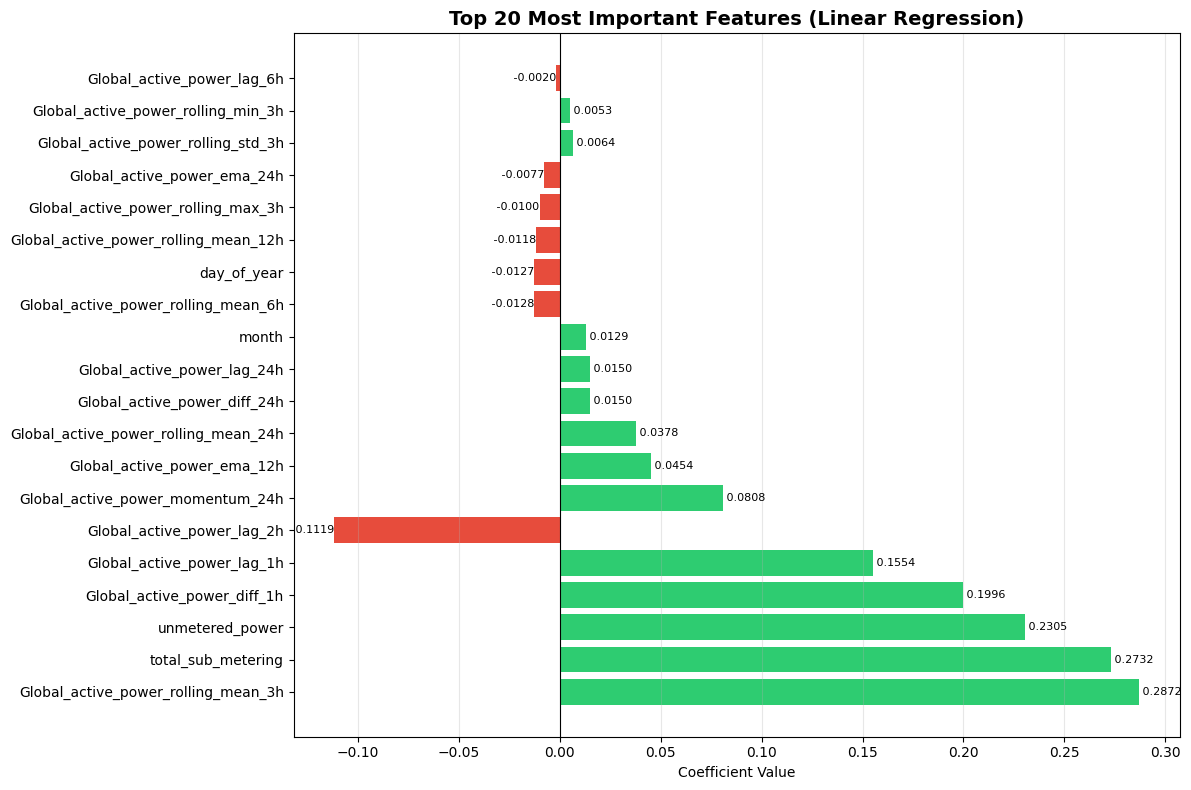

In [11]:
# Creating Feature Importance Visualization

fig2, ax = plt.subplots(figsize=(12, 8))

# Top 20 features by importance
top_features = feature_importance.head(20)
colors_imp = ['#2ECC71' if x > 0 else '#E74C3C' for x in top_features['Coefficient']]

bars = ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors_imp)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Coefficient Value')
ax.set_title('Top 20 Most Important Features (Linear Regression)', 
            fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    value = row['Coefficient']
    ax.text(value, i, f' {value:.4f}', va='center',
        ha='left' if value > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.savefig('module4_feature_importance.png', dpi=300, bbox_inches='tight')
print(" Feature importance visualization saved as 'module4_feature_importance.png'")
plt.show()

In [12]:
# Saving Model and Results

# Save metrics
metrics_df.to_csv('baseline_model_metrics.csv', index=False)
print(" Saved: baseline_model_metrics.csv")

# Save feature importance
feature_importance.to_csv('baseline_feature_importance.csv', index=False)
print(" Saved: baseline_feature_importance.csv")

# Save predictions
predictions_df = pd.DataFrame({
    'Datetime': y_test.index,
    'Actual': y_test.values,
    'Predicted': y_test_pred,
    'Error': y_test.values - y_test_pred,
    'Absolute_Error': np.abs(y_test.values - y_test_pred)
})
predictions_df.to_csv('baseline_model_predictions.csv', index=False)
print(" Saved: baseline_model_predictions.csv")

# Save model using joblib (optional - for future use)
try:
    import joblib
    joblib.dump(model_lr, 'baseline_linear_regression_model.pkl')
    joblib.dump(scaler, 'baseline_feature_scaler.pkl')
    print(" Saved: baseline_linear_regression_model.pkl")
    print(" Saved: baseline_feature_scaler.pkl")
except ImportError:
    print(" joblib not installed - model not saved as .pkl file")

 Saved: baseline_model_metrics.csv
 Saved: baseline_feature_importance.csv
 Saved: baseline_model_predictions.csv
 Saved: baseline_linear_regression_model.pkl
 Saved: baseline_feature_scaler.pkl
